In [1]:
import os
os.chdir('..')

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display
import torch, torchaudio

from IPython.display import Video


# %matplotlib widget

In [2]:
def plot_spectrogram(y, sr):
    hop_length = int(4096 * 0.4)
    plt.figure(figsize=(9, 5))
    signal = librosa.stft(y, n_fft=4096, hop_length=hop_length, window='hamming')
    signal = librosa.amplitude_to_db(np.abs(signal) ** 2)
    librosa.display.specshow(signal, sr=sr, hop_length=hop_length , x_axis="time", y_axis='log', cmap='magma')
#     plt.colorbar(format="%+2.f")
    plt.tight_layout()

    
def running_mean(x, n):
    if n % 2 == 0:
        raise ValueError("Filter length is not odd")

    aver = np.convolve(x, np.ones((n,)) / n, mode='same')
    n_half = int((n - 1) / 2)
    corr_length = np.array(range(n_half + 1, n)) / n
    aver[:n_half] = np.divide(aver[:n_half], corr_length)
    aver[-n_half:] = np.divide(aver[-n_half:], corr_length[::-1])

    return aver


def filter_and_normalize(x, filts_len):
    for filt_len in filts_len:
        x = running_mean(x, filt_len)
    
    x -= np.min(x)
    x = x / np.max(x)

    return x


def plot_signal(y, sr, f_min=0, f_max=int(1e8)):
    signal = librosa.stft(y, n_fft=4096, hop_length=int(4096 * 0.4), window='hamming')
    signal = np.abs(signal) ** 2
    
    signal = signal[f_min:f_max].sum(0)
    signal = filter_and_normalize(signal, (11, 5))
    
    x = np.linspace(0, len(y), len(signal))
    y3 = np.interp(range(len(y)), x, signal)
    
#     x_len = 9/60 * (len(y3) / sr)
    fig, ax1 = plt.subplots(figsize=(9, 5))
    ax2 = ax1.twinx()
    
    x = np.arange(len(y3)) / sr
    ax1.plot(x, y, c='g', alpha=0.2)
    ax2.plot(x, y3, c='black')
    
    ax1.set_ylabel('Amplitude')
    ax1.set_xlabel('Time [s]')
    plt.tight_layout()

    
def crop_signal(signal, from_min=1, from_sec=0, till_min=2, till_sec=0):

    convert = lambda m, s: m * 60 + s

    from_time = convert(from_min, from_sec)
    till_time = convert(till_min, till_sec)

    return signal[from_time * sr: till_time * sr]

In [3]:
audio_path = 'data/audio/20190819-Kutna Hora-L4-out-MVI_0040.MP4.wav'

y, sr = librosa.load(audio_path, sr=None)

In [4]:
y1 = crop_signal(y, 0, 0, 1, 0)

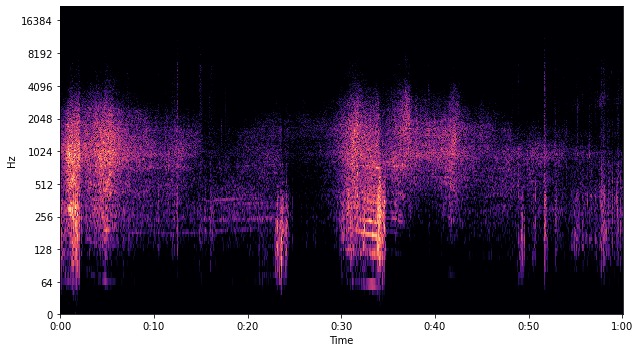

In [5]:
plot_spectrogram(y1, sr)

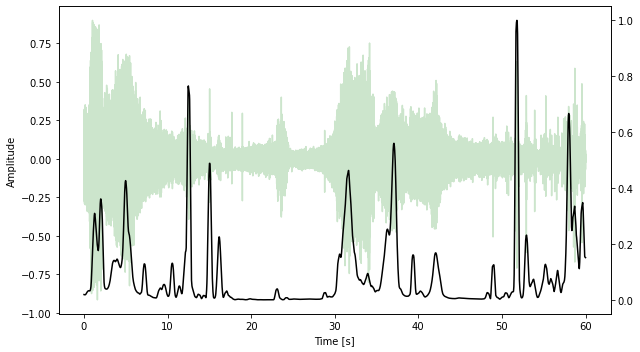

In [6]:
plot_signal(y1, sr, 500)

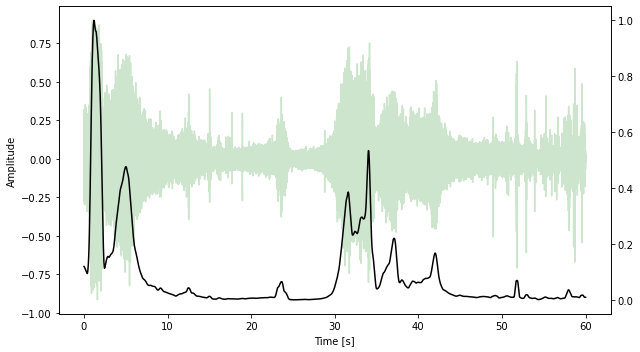

In [7]:
plot_signal(y1, sr, 0)

In [10]:
csv = r'data/csv/20210604_173354_20190819-Kutna Hora-L4-out-MVI_0040.MP4.csv'
csv = np.loadtxt(csv, delimiter=';', skiprows=1, dtype=str)

cars = {}
for row in csv:
    if row[9] != '':
        cars[row[0]] = (row[8], row[9])

### Pytorch

In [8]:
def get_melkwargs(params):
    return {
        "n_fft": params.n_fft,
        "n_mels": params.n_mels,
        "hop_length": params.hop_length
    }
    

def plot_mel(signal, params, events=None, events_from=None, events_to=None):
    plt.close('all')
    fig, ax = plt.subplots(figsize=(13, 5))
#     plt.figure(figsize=(13, 5))
    plt.title(f'Mel features from {int(events_from / 60):02.0f}:{events_from % 60:02.0f} to {int(events_to / 60):02.0f}:{events_to % 60:02.0f}')
    
    signal = crop_signal(signal, 0, events_from, 0, events_to)
#     signal = (signal - signal.mean()) / signal.std()
    
    transform = torchaudio.transforms.MelSpectrogram(sample_rate=params.sr, **get_melkwargs(params))
    
    features = transform(signal).numpy()
    
    features = librosa.power_to_db(features, ref=np.max)

    if events is not None:
        events = events.copy()
        events -= events_from
        events = events[events < events_to]
        plt.vlines(events, 0, 40000, linewidth=2, color='white')
                
    img = librosa.display.specshow(features, sr=params.sr, hop_length=params.hop_length , x_axis="time", y_axis='mel', cmap='magma')
#     plt.colorbar(img, ax=ax, format='%+2.0f dB')
    
    plt.tight_layout()

def plot_mfcc(signal, params, events=None, events_from=None, events_to=None, delta=None):
    
    plt.close('all')
    plt.figure(figsize=(13, 5))
    plt.title(f'MFCC features from {int(events_from / 60):02.0f}:{events_from % 60:02.0f} to {int(events_to / 60):02.0f}:{events_to % 60:02.0f}')
    
    signal = crop_signal(signal, 0, events_from, 0, events_to)
#     signal = (signal - signal.mean()) / signal.std()
    
    transform = torchaudio.transforms.MFCC(sample_rate=params.sr, n_mfcc=params.n_mfcc, melkwargs=get_melkwargs(params))
    
    features = transform(signal).numpy()
    
    if delta is not None:
        features = librosa.feature.delta(features, order=delta)

    if events is not None:
        events = events.copy()
        events -= events_from
        events = events[events < events_to]
        plt.vlines(events, 0, 40000, linewidth=0.5, color='white')
        
    librosa.display.specshow(features, hop_length=params.hop_length, sr=params.sr, x_axis="time", cmap='magma')
    
    plt.tight_layout()

In [11]:
audio_path = 'data/audio/20190819-Kutna Hora-L4-out-MVI_0040.MP4.wav'
signal, sr = torchaudio.load(audio_path)
signal = signal.mean(0)

labels_path = 'data/labels/20190819-Kutna Hora-L4-out-MVI_0040.MP4.txt'
events = np.loadtxt(labels_path)

In [20]:
minute = lambda x: x * 60

events_from = minute(1)
interval = minute(2)
events_to = events_from + interval

In [26]:
from easydict import EasyDict
params = EasyDict()
params.n_fft = 1024
params.n_mels = 64
params.n_mfcc = 16
params.sr = 44100
params.hop_length = 128

In [27]:
# import IPython.display as ipd
# S = crop_signal(signal, 0, events_from, 0, events_to)
# ipd.Audio(S.tolist(), rate=sr)
# plt.plot((S - S.mean()) / S.std(), alpha=0.5);
# plt.plot(S, alpha=0.5);

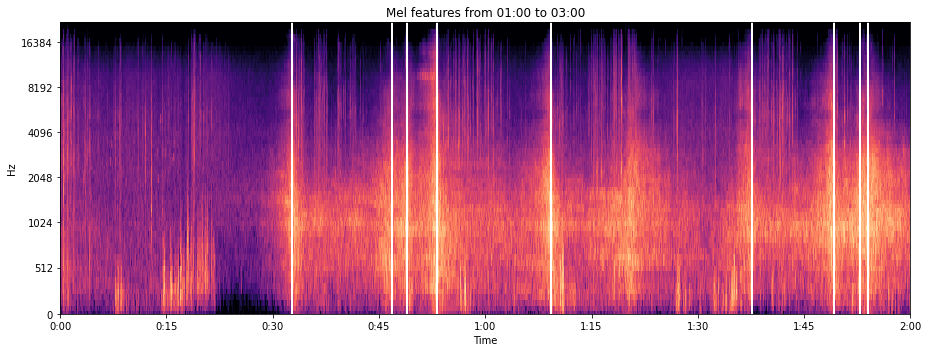

In [28]:
plot_mel(signal, params, events, events_from, events_to)

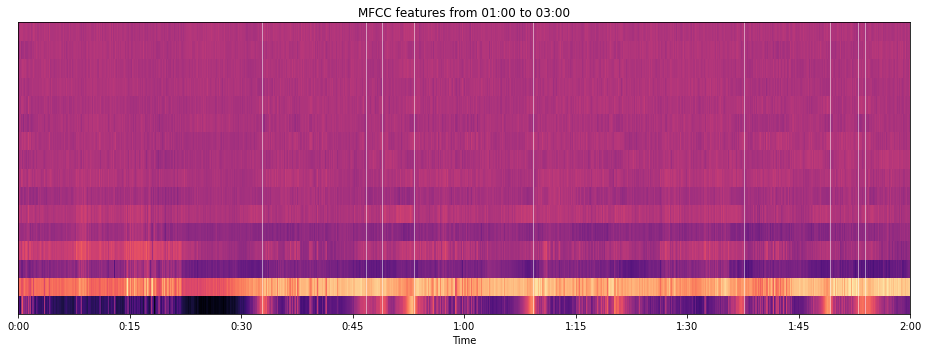

In [29]:
plot_mfcc(signal, params, events, events_from, events_to)

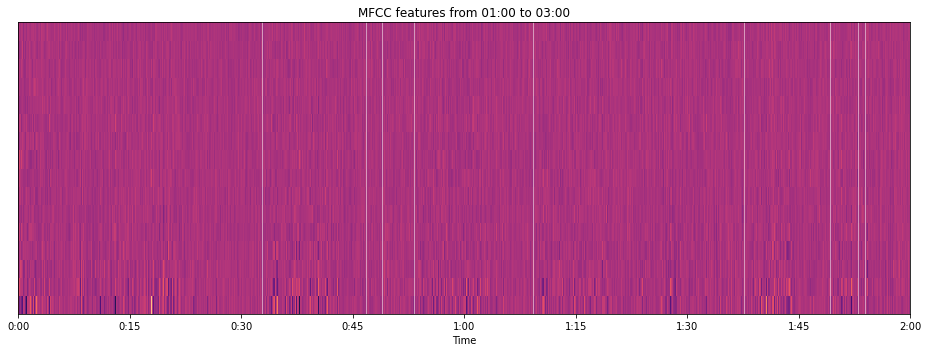

In [30]:
plot_mfcc(signal, params, events, events_from, events_to, delta=1)

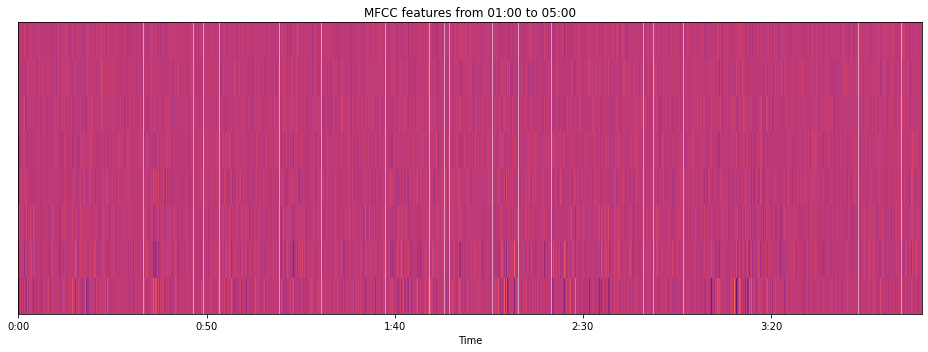

In [17]:
plot_mfcc(signal, params, events, events_from, events_to, delta=2)